# Tutorial 2: 
# Image Classification Model: Convolution Neural Networks

# 1- Importing libraries

In [2]:
conda install keras

Note: you may need to restart the kernel to use updated packages.



Examining python=3.8: 100%|##########| 3/3 [00:01<00:00,  2.27it/s]
                                                                   

Examining conflict for keras python:  33%|###3      | 1/3 [00:00<?, ?it/s]
                                                                          

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - keras -> python[version='>=3.5,<3.6.0a0|>=3.6,<3.7.0a0']

Your python: python=3.8

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.

The following specifications were found to be incompatible with your system:

  - feature:/win-64::__cuda==9.1=0

Yo


Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed


In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
%matplotlib inline

ModuleNotFoundError: No module named 'keras'

# 2- Data pre-processing and data augmentation

Image Shape: (28, 28)


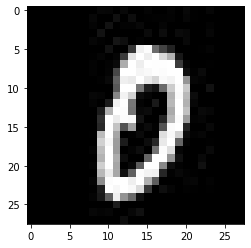

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

im = Image.open("data/testing/0/346.jpg")
im = np.array(im)
print("Image Shape:", im.shape)
plt.imshow(im, cmap="gray")

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                  shear_range=0.2, #is for randomly applying shearing transformations
                                  zoom_range=0.2, #is for randomly zooming inside pictures
                                  horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                  rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                  width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                  height_shift_range=0.2, 
                                  fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                 )


validation_generator = val_datagen.flow_from_directory("data/testing", batch_size=1, 
                                                        class_mode='categorical', 
                                                        color_mode='grayscale', 
                                                        target_size=(28,28)
                                                       )

In [ ]:
for x, y in validation_generator:
    print(x.shape)
    print(y)
    plt.imshow(x[0,:,:,0], cmap='gray')
    break

In [ ]:
validation_generator.classes

In [ ]:
dictclass = validation_generator.class_indices

In [ ]:
dictclass['5']

# 3- Object Oriented Programming

In [ ]:
class Image_Classifier():
    def __init__(self, train_folder='data/train', validation_folder='data/validation', 
                  inshape=(28,28,1), num_classes=10, num_train=1000, num_validation=200):
        self.train_folder = train_folder
        self.validation_folder =  validation_folder
        self.inshape = inshape
    
        self.num_classes = num_classes
        self.num_train = num_train
        self.num_validation = num_validation
        
    def model(self, inshape=(28,28,1), num_classes=10, learning_rate=0.001):
        '''
            Three steps to Convolution
                1. Convolution
                2. Activation
                3. Polling
            Repeat Steps 1,2,3 for adding more hidden layers
                4. After that make a fully connected network
            This fully connected network gives ability to the CNN
            to classify the samples
        '''
        model = Sequential()

        model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                         input_shape=inshape, data_format="channels_last"))
        
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu', 
                         kernel_initializer='glorot_uniform', bias_initializer='zeros'))


        model.add(MaxPooling2D(pool_size=(2,2)))
        
        model.add(Flatten())
    
        model.add(Dropout(rate=0.8)) # rate: rate of nodes to be keeped

        model.add(Dense(units=512, activation='relu'))
        
        model.add(Dropout(rate=0.8))

        model.add(Dense(num_classes, activation='softmax'))
        
        # Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class.
        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model
    
    def train(self, batch_size=128, epochs=12, learning_rate=0.001, model_file="my_model.h5", refine = False):
        '''
            Train Process
        '''
        # this is the augmentation configuration we will use for training
        train_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                            shear_range=0.2, #is for randomly applying shearing transformations
                                            zoom_range=0.2, #is for randomly zooming inside pictures
                                            horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                            #rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                            #width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                            #height_shift_range=0.2, 
                                            #fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                          )

        # this is the augmentation configuration we will use for testing:
        # only rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)

        # this is a generator that will read pictures found in
        # subfolers of 'data/train', and indefinitely generate
        # batches of augmented image data
        train_generator = train_datagen.flow_from_directory(self.train_folder,  # this is the target directory
                                                            target_size=(28,28),  # all images will be resized to 150x150
                                                            batch_size=batch_size, 
                                                            color_mode='grayscale',
                                                            #class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels
                                                           )
        # this is a similar generator, for validation data
        validation_generator = test_datagen.flow_from_directory(self.validation_folder, 
                                                                target_size=(28,28),
                                                                batch_size=batch_size, 
                                                                color_mode='grayscale',
                                                                #class_mode='binary'
                                                               )
        if refine:
            model = load_model(model_file)
        else:
            model = self.model(inshape=self.inshape, num_classes=self.num_classes, learning_rate=learning_rate)
        
        ts = time.time()
        tbCallBack = TensorBoard(log_dir='./logs/' + str(ts), histogram_freq=0, write_graph=True, write_images=True)
        
        # To launch tensorbord
        # tensorboard --logdir ./logs
        model.fit_generator(train_generator,
                            steps_per_epoch=self.num_train // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=self.num_validation // batch_size,
                            callbacks=[tbCallBack])
        
        # You can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:
        # 1- the architecture of the model, allowing to re-create the model
        # 2- the weights of the model
        # 3- the training configuration (loss, optimizer)
        # 4- the state of the optimizer, allowing to resume training exactly where you left off.

        model.save(model_file)
        
        
    def predict(self, x, model_file="my_model.h5"):
        model = load_model(model_file)
        prediction = model.predict(x)
        return prediction

# 4- Training Step

In [ ]:
im_classifier = Image_Classifier(train_folder = 'data/training', 
                                 validation_folder = 'data/testing', 
                                 inshape=(28,28,1), num_classes=10,
                                 num_train=60000, num_validation=1000)

im_classifier.train(batch_size=128, epochs=12, learning_rate=0.001)
# im_classifier.train(batch_size=128, epochs=20, learning_rate=0.0001, refine=True, model_file="my_model.h5")

# 5- Inference Step

In [ ]:
im = Image.open("data/testing/6/870.jpg")
im = np.array(im)
im = np.expand_dims(im, axis=0)
im = np.expand_dims(im, axis=3)
print(im.shape)
im_classifier = Image_Classifier()
prediction = im_classifier.predict(im, model_file="my_model.h5")
prediction_digit = prediction[0].argmax()
print("The corresponding image digit is :", prediction_digit)